In [1]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

c:\python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# using JD as its not as stable
df_g=web.DataReader('GOOGL',data_source='yahoo',start='04-01-2003',end='07-15-2020')

In [3]:
print(df_g)

                   High          Low         Open        Close      Volume  \
Date                                                                         
2004-08-19    52.082081    48.028027    50.050049    50.220219  44659000.0   
2004-08-20    54.594593    50.300301    50.555557    54.209209  22834300.0   
2004-08-23    56.796795    54.579578    55.430431    54.754753  18256100.0   
2004-08-24    55.855854    51.836838    55.675674    52.487488  15247300.0   
2004-08-25    54.054054    51.991993    52.532532    53.053055   9188600.0   
...                 ...          ...          ...          ...         ...   
2020-07-09  1529.140015  1495.589966  1509.930054  1518.660034   2091800.0   
2020-07-10  1541.339966  1500.719971  1513.250000  1539.010010   1795900.0   
2020-07-13  1576.359985  1506.560059  1549.939941  1512.229980   2147700.0   
2020-07-14  1522.800049  1485.930054  1492.790039  1520.859985   1905400.0   
2020-07-15  1536.329956  1497.829956  1523.229980  1516.880005  

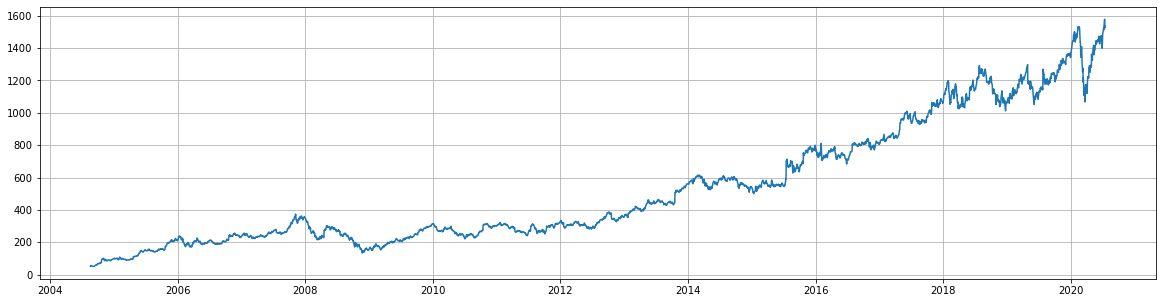

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df_g.High)
plt.grid()

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing values
ser = df_g.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [6]:
int(series.shape[0]*0.9)

3603

In [7]:
# fixed input size to model, last 30 days
Window = 30
Predday = 7

# To split the data into 90:10
Trainsplit = 0.9

cut = int(series.shape[0]*Trainsplit)

# train
closetrain = series[:cut]
# test
closetest = series[cut:-(Window+Predday)]
# forecast for future 7 days
closeforecast = series[-(Window+Predday):]

closetrain.shape, closetest.shape , closeforecast.shape

((3603, 1), (364, 1), (37, 1))

In [8]:
def windowed_dataset(series, window_size = 31,predday = 7, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-7], tf.squeeze(w[-7:])))
    return ds.batch(batch_size).prefetch(3)

trainbatches =  windowed_dataset(closetrain)
testbatches =  windowed_dataset(closetest,batch_size=8)


In [9]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

In [10]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(7)
np.random.seed(7)

model = tf.keras.Sequential()
model.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model.add(layers.LSTM(j, return_sequences=True))
model.add(layers.LSTM(128))
for i in [64,64,7]:
    model.add(layers.Dense(i, activation="selu"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 4

In [11]:
optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h = model.fit(trainbatches,epochs=100,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/100
112/112 [==============================] - 15s 133ms/step - loss: 3.0519e-04 - mse: 6.1039e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 2/100
112/112 [==============================] - 14s 125ms/step - loss: 1.0850e-04 - mse: 2.1700e-04 - val_loss: 9.5156e-04 - val_mse: 0.0019
Epoch 3/100
112/112 [==============================] - 15s 133ms/step - loss: 1.5974e-04 - mse: 3.1947e-04 - val_loss: 8.4224e-04 - val_mse: 0.0017
Epoch 4/100
112/112 [==============================] - 19s 169ms/step - loss: 1.1774e-04 - mse: 2.3548e-04 - val_loss: 6.7144e-04 - val_mse: 0.0013
Epoch 5/100
112/112 [==============================] - 16s 140ms/step - loss: 8.9152e-05 - mse: 1.7830e-04 - val_loss: 7.0692e-04 - val_mse: 0.0014
Epoch 6/100
112/112 [==============================] - 15s 135ms/step - loss: 8.9582e-05 - mse: 1.7916e-04 - val_loss: 6.1562e-04 - val_mse: 0.0012
Epoch 7/100
112/112 [==============================] - 12s 109ms/step - loss: 1.1780e-04 - mse: 2.3561e-04 - val_los

112/112 [==============================] - 16s 142ms/step - loss: 4.1988e-05 - mse: 8.3975e-05 - val_loss: 6.6944e-04 - val_mse: 0.0013
Epoch 56/100
112/112 [==============================] - 21s 184ms/step - loss: 4.0981e-05 - mse: 8.1961e-05 - val_loss: 3.3354e-04 - val_mse: 6.6708e-04
Epoch 57/100
112/112 [==============================] - 16s 139ms/step - loss: 5.6087e-05 - mse: 1.1217e-04 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 58/100
112/112 [==============================] - 18s 159ms/step - loss: 4.8702e-05 - mse: 9.7404e-05 - val_loss: 2.8156e-04 - val_mse: 5.6311e-04
Epoch 59/100
112/112 [==============================] - 15s 130ms/step - loss: 4.8712e-05 - mse: 9.7423e-05 - val_loss: 3.9696e-04 - val_mse: 7.9393e-04
Epoch 60/100
112/112 [==============================] - 13s 118ms/step - loss: 4.1656e-05 - mse: 8.3312e-05 - val_loss: 2.7951e-04 - val_mse: 5.5902e-04
Epoch 61/100
112/112 [==============================] - 15s 133ms/step - loss: 4.7078e-05 - mse: 9.4155e-05

In [12]:
for t in hist.keys():
    print(t)

loss
mse
val_loss
val_mse


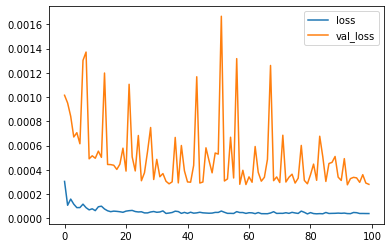

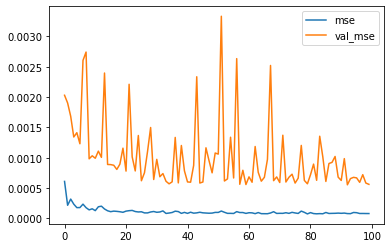

In [13]:
for i in ["loss","mse"]:
    plt.plot(hist[i],label = i)
    plt.plot(hist["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()


In [14]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

(8, 7)

In [15]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

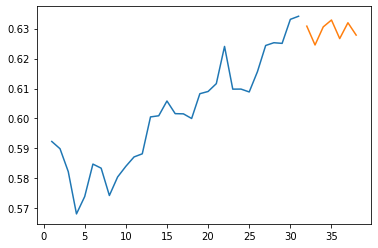

In [16]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)

time=list(range(1,32))
time2=list(range(32,39))
plt.plot(time,x1[0])
plt.plot(time2,output[0])

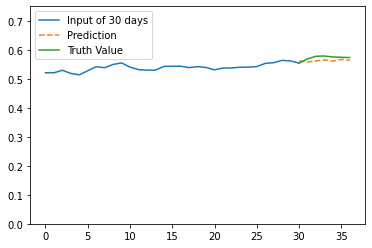

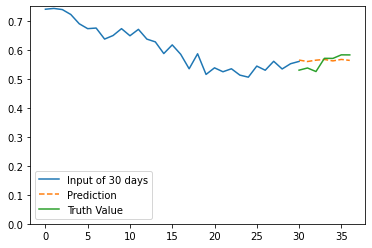

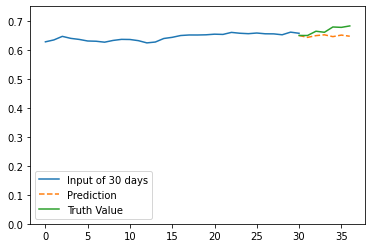

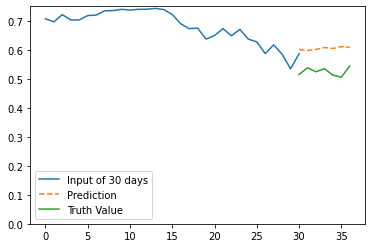

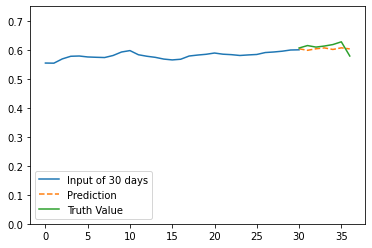

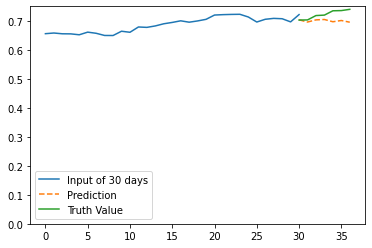

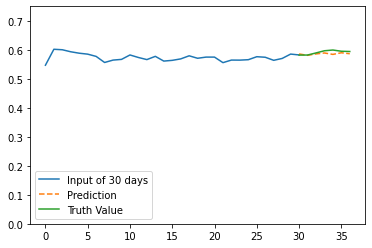

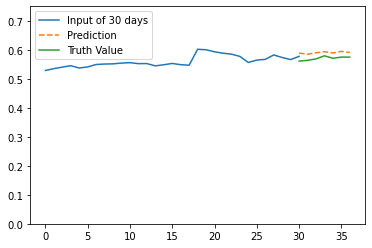

In [17]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [18]:
model.evaluate(testbatches)

41/41 [==============================] - 1s 18ms/step - loss: 2.8106e-04 - mse: 5.6212e-04


[0.0002810590376611799, 0.0005621180753223598]

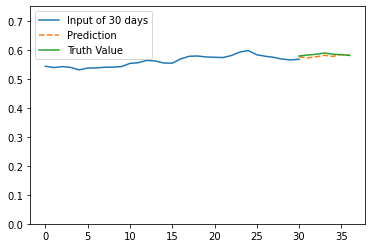

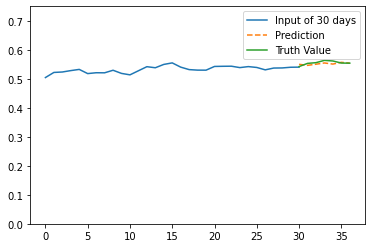

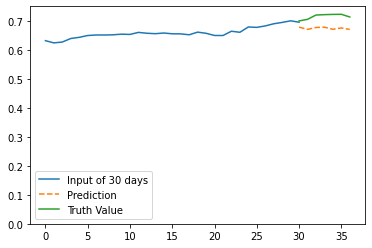

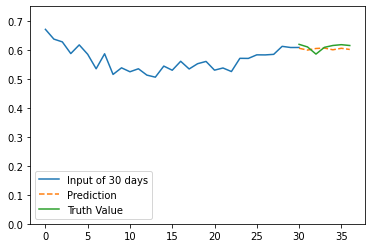

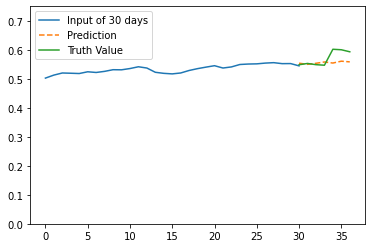

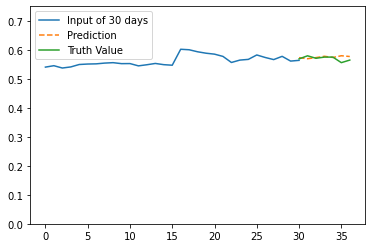

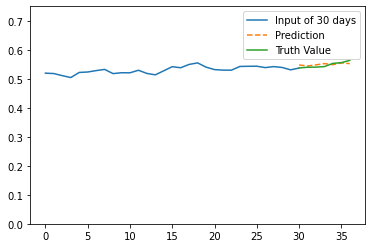

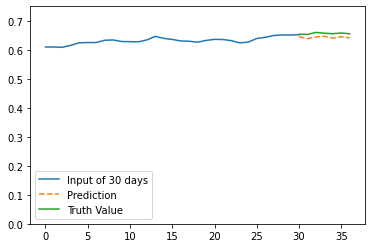

In [19]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [20]:
df_test=web.DataReader('GOOGL',data_source='yahoo',start='03-01-2020',end='07-20-2020')

In [21]:
len(df_test)

98

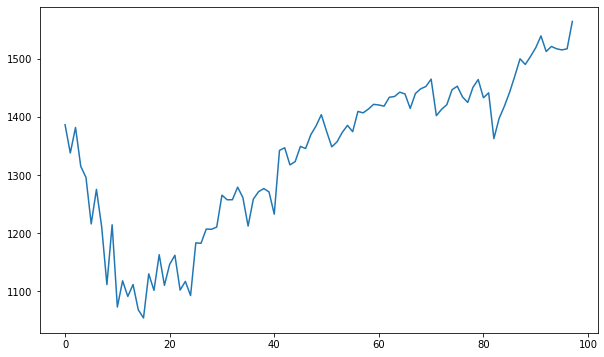

In [22]:
new_time_step=[]
for i in range(df_test.shape[0]):
    new_time_step.append(i)

close_data=df_test['Close']
new_time = np.array(new_time_step)
plt.figure(figsize=(10, 6))
plt.plot(new_time,close_data)

In [23]:
x_test=close_data
x_test=np.array(x_test).reshape(-1,1)

In [24]:
scaler1=MinMaxScaler(feature_range=(0,0.75))
xt1=scaler1.fit_transform(x_test)
xt1

array([[0.4887926 ],
       [0.41728138],
       [0.48184751],
       [0.38349752],
       [0.35551098],
       [0.23787062],
       [0.32524385],
       [0.23067533],
       [0.08448929],
       [0.23563403],
       [0.02776578],
       [0.09406828],
       [0.05453092],
       [0.08466585],
       [0.0207176 ],
       [0.        ],
       [0.11165174],
       [0.06987796],
       [0.16007639],
       [0.08259109],
       [0.13563604],
       [0.15864897],
       [0.07058422],
       [0.09255267],
       [0.05675278],
       [0.18990202],
       [0.1889752 ],
       [0.22493674],
       [0.22430395],
       [0.22995435],
       [0.31061779],
       [0.29894949],
       [0.29914078],
       [0.33087934],
       [0.30461444],
       [0.23252934],
       [0.30058275],
       [0.31935815],
       [0.32734789],
       [0.31890192],
       [0.26259046],
       [0.42384405],
       [0.43049475],
       [0.38726427],
       [0.39547494],
       [0.43390855],
       [0.42862619],
       [0.463

In [25]:
xt332=windowed_dataset(xt1)

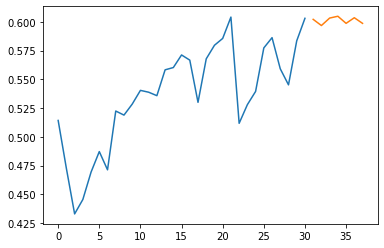

In [26]:
a,b=next(iter(xt332))
p=model.predict(a)
plt.plot(np.arange(0,31),a[0])
plt.plot(np.arange(31,38),p[0])

In [27]:
model.save('Model1_pred_7days.h5')

In [28]:
#Model 2:
def windowed_dataset1(series, window_size = 62,predday = 14, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-14], tf.squeeze(w[-14:])))
    return ds.batch(batch_size).prefetch(3)

train2batches =  windowed_dataset1(closetrain)
test2batches =  windowed_dataset1(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(14)
np.random.seed(14)

model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model2.add(layers.LSTM(j, return_sequences=True))
model2.add(layers.LSTM(128))
for i in [64,64,14]:
    model2.add(layers.Dense(i, activation="selu"))

print(model2.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model2.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h1 = model2.fit(train2batches,epochs=20,validation_data=test2batches,verbose=1)
hist1 = h1.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 14)                9

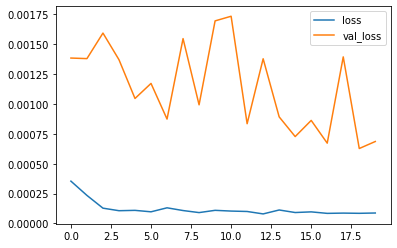

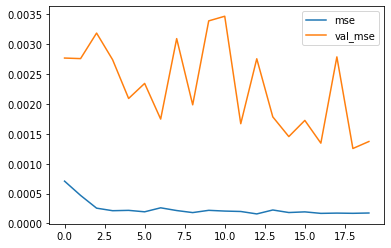

In [29]:
for i in ["loss","mse"]:
    plt.plot(hist1[i],label = i)
    plt.plot(hist1["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

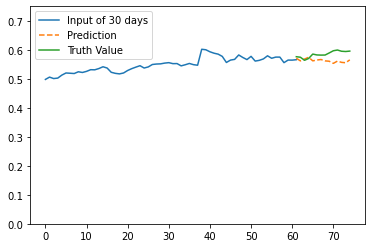

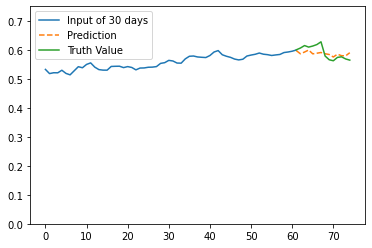

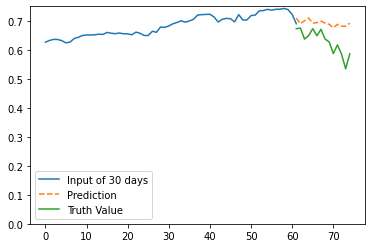

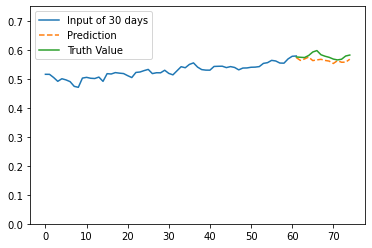

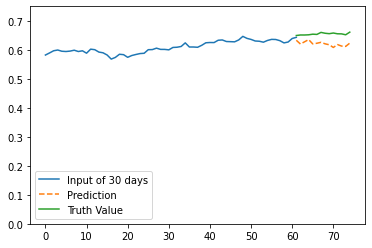

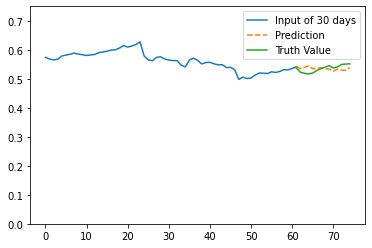

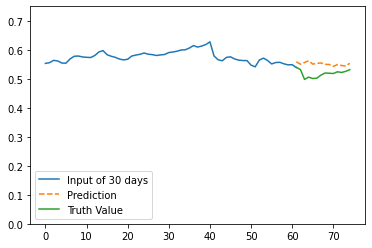

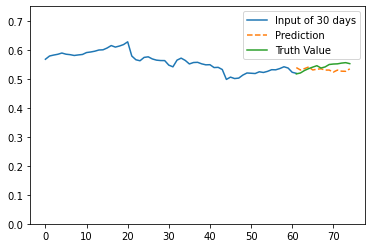

In [30]:
def visualplotloss2(dataset):
    x,y = next(iter(dataset))
    output = model2.predict(x)
    timecorr =list(range(61,75))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss2(test2batches)

Text(0.5, 1.0, 'Prediction for 14 Days')

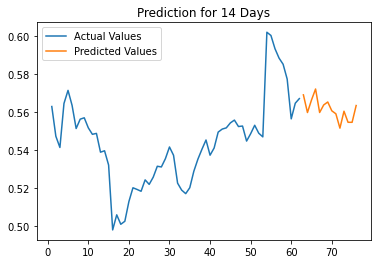

In [31]:
x2,y2 = next(iter(test2batches))
output2 = model2.predict(x2)

time=list(range(1,63))
time2=list(range(63,77))
plt.plot(time,x2[0])
plt.plot(time2,output2[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 14 Days')

In [32]:
model2.save('Model2_pred_14days.h5')

In [50]:
#Model 3:
def windowed_dataset2(series, window_size = 90,predday = 21, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-21], tf.squeeze(w[-21:])))
    return ds.batch(batch_size).prefetch(3)

train3batches =  windowed_dataset2(closetrain)
test3batches =  windowed_dataset2(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(21)
np.random.seed(21)

model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model3.add(layers.LSTM(j, return_sequences=True))
model3.add(layers.LSTM(128))
for i in [64,64,21]:
    model3.add(layers.Dense(i, activation="selu"))

print(model3.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model3.compile(optimizer = 'adam', loss ='mse', metrics=["mse"])
h2 = model3.fit(train3batches,epochs=30,validation_data=test3batches,verbose=1)
hist2 = h2.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1

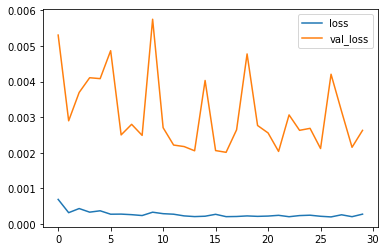

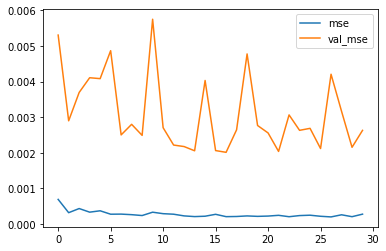

In [51]:
for i in ["loss","mse"]:
    plt.plot(hist2[i],label = i)
    plt.plot(hist2["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

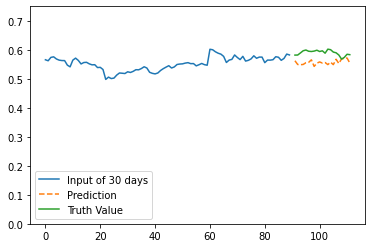

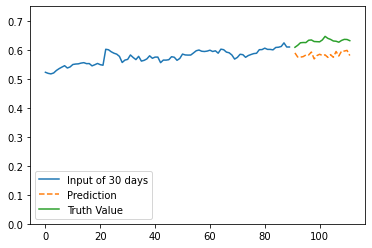

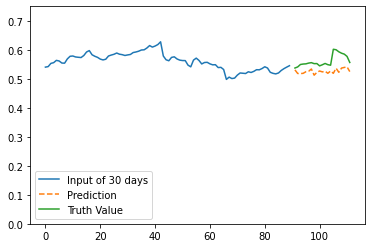

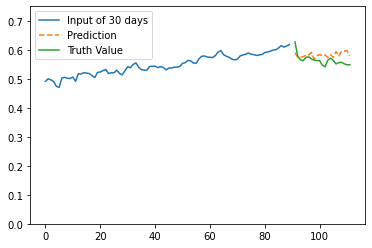

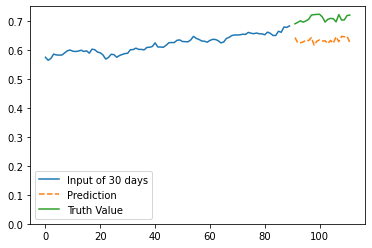

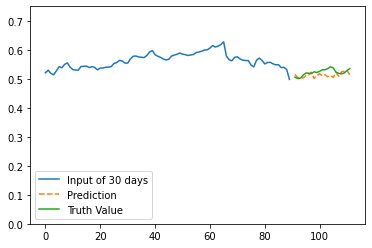

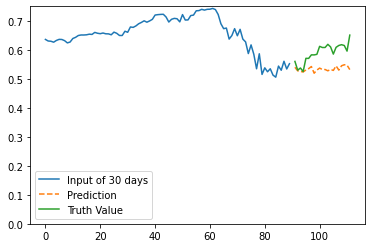

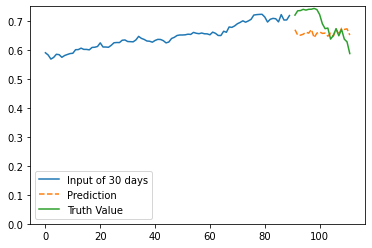

In [52]:
def visualplotloss3(dataset):
    x,y = next(iter(dataset))
    output = model3.predict(x)
    timecorr =list(range(91,112))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss3(test3batches)

Text(0.5, 1.0, 'Prediction for 21 Days')

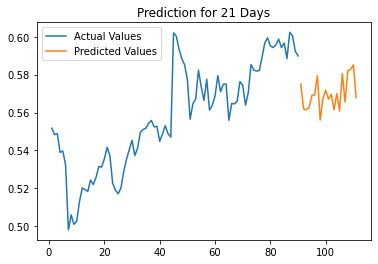

In [54]:
x3,y3 = next(iter(test3batches))
output3 = model3.predict(x3)

time=list(range(1,91))
time2=list(range(91,112))
plt.plot(time,x3[0])
plt.plot(time2,output3[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 21 Days')

In [55]:
model3.save('Model_3_Pred21_Days.h5')

In [38]:
#Model 4:
def windowed_dataset3(series, window_size = 120,predday = 28, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-28], tf.squeeze(w[-28:])))
    return ds.batch(batch_size).prefetch(3)

train4batches =  windowed_dataset3(closetrain)
test4batches =  windowed_dataset3(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(28)
np.random.seed(28)

model4 = tf.keras.Sequential()
model4.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model4.add(layers.LSTM(j, return_sequences=True))
model4.add(layers.LSTM(128))
for i in [64,64,28]:
    model4.add(layers.Dense(i, activation="selu"))

print(model4.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model4.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h3 = model4.fit(train4batches,epochs=20,validation_data=test4batches,verbose=1)
hist3 = h3.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1

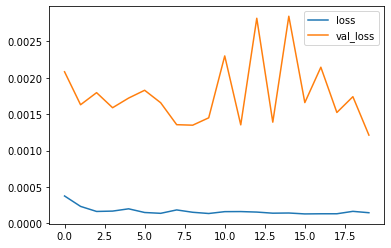

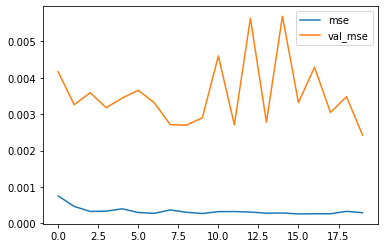

In [39]:
for i in ["loss","mse"]:
    plt.plot(hist3[i],label = i)
    plt.plot(hist3["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

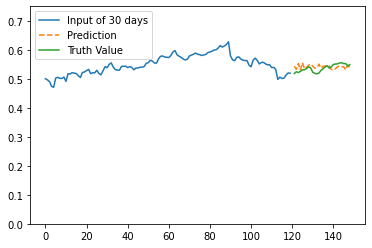

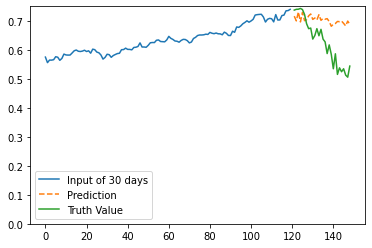

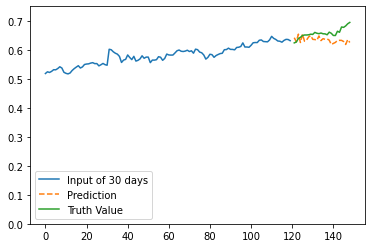

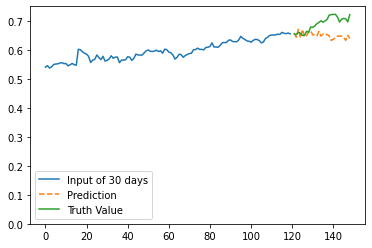

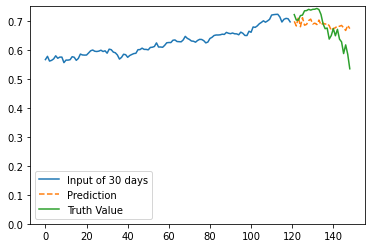

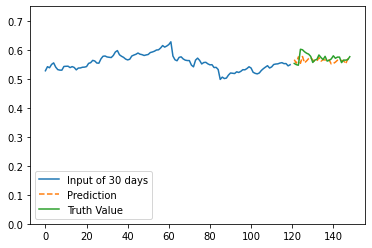

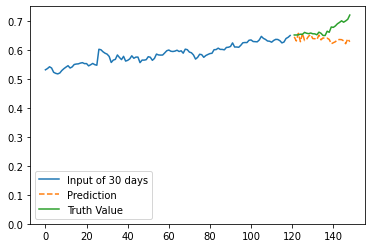

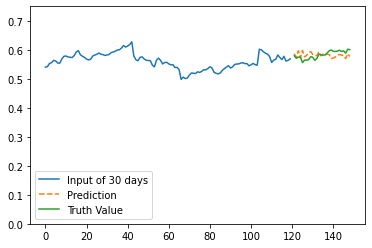

In [40]:
def visualplotloss4(dataset):
    x,y = next(iter(dataset))
    output = model4.predict(x)
    timecorr =list(range(121,149))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss4(test4batches)

Text(0.5, 1.0, 'Prediction for 28 Days')

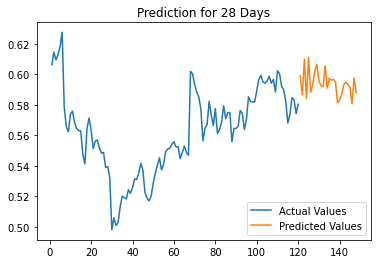

In [41]:
x4,y4 = next(iter(test4batches))
output4 = model4.predict(x4)

time=list(range(1,121))
time2=list(range(121,149))
plt.plot(time,x4[0])
plt.plot(time2,output4[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 28 Days')

In [42]:
model4.save('Model_4_Pred28_Days.h5')

In [43]:
#Model 5:
def windowed_dataset4(series, window_size = 150,predday = 35, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-35], tf.squeeze(w[-35:])))
    return ds.batch(batch_size).prefetch(3)

train5batches =  windowed_dataset4(closetrain)
test5batches =  windowed_dataset4(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(35)
np.random.seed(35)

model5 = tf.keras.Sequential()
model5.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model5.add(layers.LSTM(j, return_sequences=True))
model5.add(layers.LSTM(128))
for i in [64,64,35]:
    model5.add(layers.Dense(i, activation="selu"))

print(model5.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model5.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h4 = model5.fit(train5batches,epochs=30,validation_data=test5batches,verbose=1)
hist4 = h4.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                2

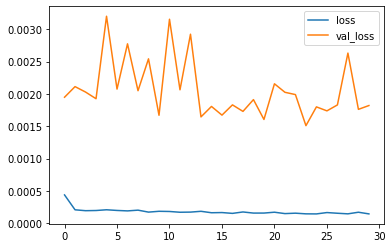

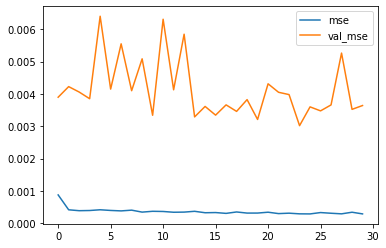

In [44]:
for i in ["loss","mse"]:
    plt.plot(hist4[i],label = i)
    plt.plot(hist4["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

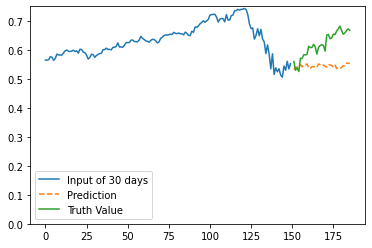

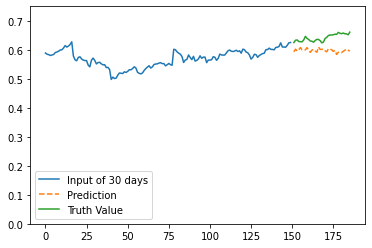

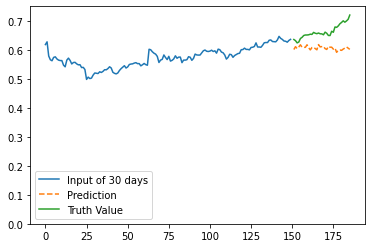

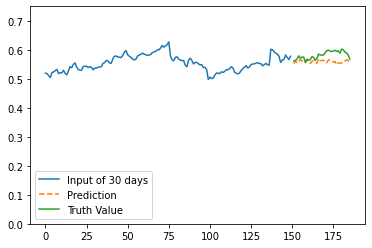

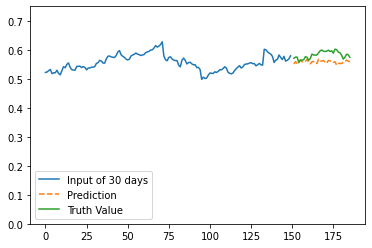

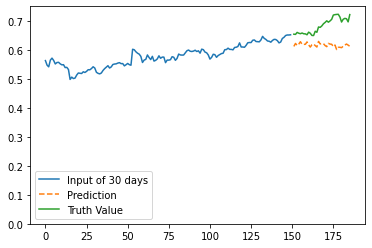

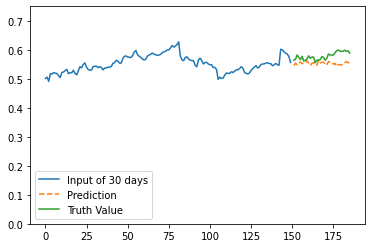

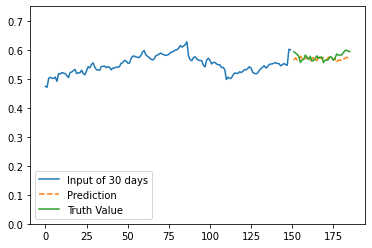

In [45]:
def visualplotloss5(dataset):
    x,y = next(iter(dataset))
    output = model5.predict(x)
    timecorr =list(range(151,186))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss5(test5batches)

Text(0.5, 1.0, 'Prediction for 35 Days')

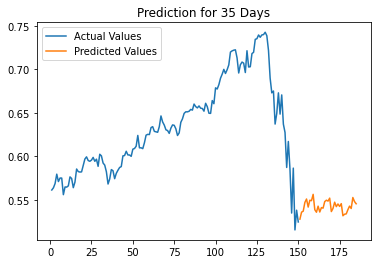

In [46]:
x5,y5 = next(iter(test5batches))
output5 = model5.predict(x5)

time=list(range(1,151))
time2=list(range(151,186))
plt.plot(time,x5[0])
plt.plot(time2,output5[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 35 Days')

In [47]:
model5.save('Model5_Pred_35Days.h5')